In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pwd

/content


In [2]:
%cd drive/My\ Drive/논문

/content/drive/My Drive/논문


In [2]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (8,456 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletyp

In [1]:
!apt-get update -qq
!apt-get install fonts-nanum* -qq
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'
font_name = fm.FontProperties(fname=path, size=10).get_name()

plt.rc('font', family=font_name)

fm._rebuild()

processing time : 0.020183086395263672 s
processing time : 0.006604909896850586 s


findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0.0, flags=flags)
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44053 missing from current font.
  font.set_text(s, 0

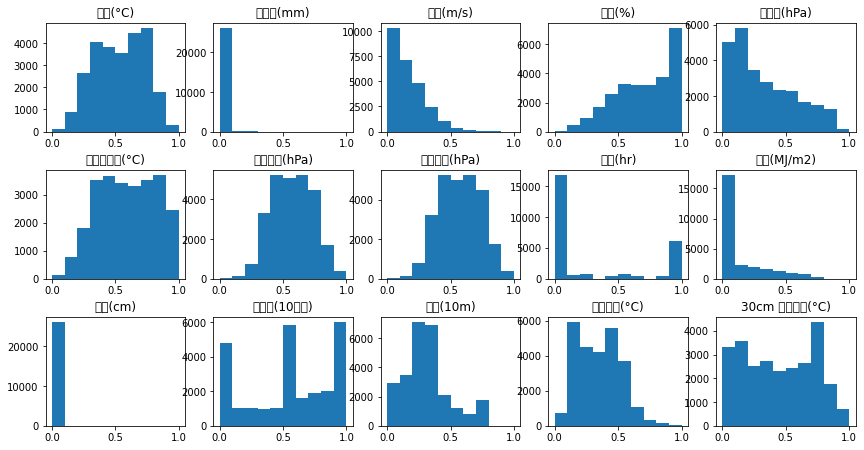

In [1]:

'''
기온(°C)  ->  spline
강수량(mm)  ->  0 + 분자료
풍속(m/s)  ->  spline
습도(%)  ->  spline
증기압(hPa)  ->  spline
이슬점온도(°C)  ->  spline
현지기압(hPa)  ->  spline
해면기압(hPa)  ->  spline
일조(hr)  ->  0
일사(MJ/m2)  ->  0
적설(cm)  ->  0
전운량(10분위)  ->  linear
시정(10m)  ->  spline
지면온도(°C)  ->  spline
지중온도(°C)  ->  ?
'''

# 관측 데이터 처리

import pandas as pd
import numpy as np
import utils


data_obs = pd.read_csv('data_obs.csv')


# 관측데이터 컬럼별 보간 방법 및 노멀라이즈 여부 결정과 풍향 더미화 진행

c_spline = ['기온(°C)', '풍속(m/s)', '습도(%)', '증기압(hPa)', '이슬점온도(°C)', '현지기압(hPa)','해면기압(hPa)', 
            '지면온도(°C)', '5cm 지중온도(°C)', '10cm 지중온도(°C)','20cm 지중온도(°C)', '30cm 지중온도(°C)', "시정(10m)"]

c_linear = ['전운량(10분위)', "풍향(16방위)"]

# spline 보간 좀 오래걸림. 실험할 때 귀찮으면 linear 돌려서 실험하는거 추천
utils.dataframe_interpolation_by_linear(data_obs, c_spline) 
utils.dataframe_interpolation_by_linear(data_obs, c_linear)

value = {"강수량(mm)":0, "적설(cm)":0, "일조(hr)":0, "일사(MJ/m2)":0, 
         "전운량(10분위)":np.mean(data_obs["전운량(10분위)"]), "시정(10m)":np.mean(data_obs["시정(10m)"])}


data_obs.fillna(value, inplace=True)


data_obs = utils.wind_direction_dummies(data_obs, "풍향(16방위)", True)



import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumGothic'


exclude_column_list = ["time", "5cm 지중온도(°C)", "10cm 지중온도(°C)", "20cm 지중온도(°C)", "풍향(16방위)_1.0", "풍향(16방위)_2.0", "풍향(16방위)_3.0", "풍향(16방위)_4.0",
                       "풍향(16방위)_5.0", "풍향(16방위)_6.0", "풍향(16방위)_7.0", "dangjin_floating"]


data_obs = utils.dataframe_normalize(data_obs, exclude_column_list)
plt.rc('font', family='NanumBarunGothic')
utils.hist_features(data_obs, exclude_column_list)






In [2]:

'''
3시간기온 --> pass + spline
습도 --> pass + spline
풍향 --> pass + linear + 8방위 변환 + 더미화
풍속 --> pass + spline
하늘상태 --> pass + linear
강수형태 --> pass + linear
6시간강수 --> 배분하기.
6시간적설 --> 배분하기.
일최고기온 --> pass + spline
일최저기온 --> pass + spline
강수확률 --> pass + linear
'''

# 예보 데이터 처리

# 3시간 간격 -> 1시간 간격, 강수량 배분, 컬럼별 보간 및 노멀라이즈, 풍향 더미화 

data_fcst = pd.read_csv('data_fcst.csv')


data_fcst = utils.fcst_augment(data_fcst)

data_fcst = utils.divide_cumulative_rainfall(data_fcst)


In [3]:
data_fcst

,time_index,3시간기온,습도,풍향,풍속,하늘상태,강수형태,6시간강수량,6시간적설,일최고기온,일최저기온,강수확률
0,2018-01-01 00:00:00,-1.0,75.0,337.0,6.0,2.0,0.0,0.0,0.0,3.0,-3.0,10.0
1,2018-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN
2,2018-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN
3,2018-01-01 03:00:00,-2.0,80.0,332.0,4.2,1.0,0.0,0.0,0.0,3.0,-3.0,0.0
4,2018-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
26300,2020-12-31 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN
26301,2020-12-31 21:00:00,-3.0,50.0,320.0,6.1,4.0,0.0,0.0,0.0,1.0,-7.0,30.0
26302,2020-12-31 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN
26303,2020-12-31 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN


In [4]:
'''
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

plt.rc('font', family='NanumBarunGothic')
#msno.matrix(data_obs)
msno.bar(data_fcst)
'''

"\nimport matplotlib.pyplot as plt\nimport seaborn as sns\nimport missingno as msno\n\nplt.rc('font', family='NanumBarunGothic')\n#msno.matrix(data_obs)\nmsno.bar(data_fcst)\n"

processing time : 8.184959888458252 s
processing time : 0.025860309600830078 s


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44036 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44036 missing from current font.
  font.set_te

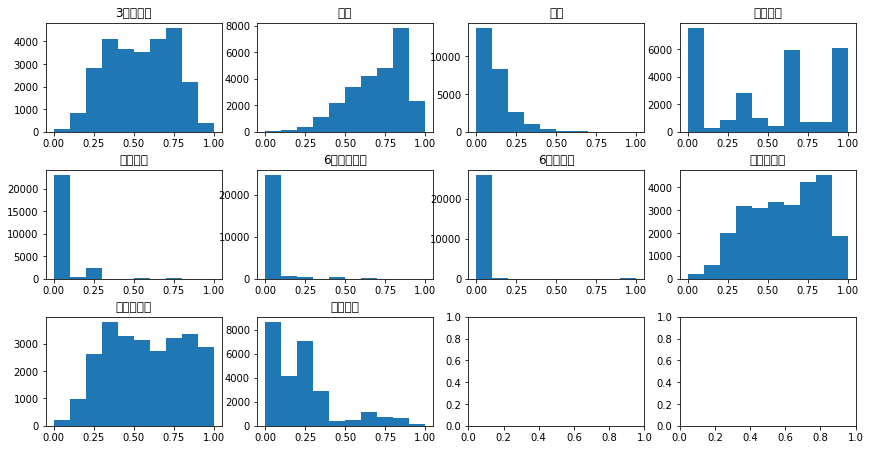

In [5]:


utils.dataframe_interpolation_by_spline(data_fcst, ["3시간기온", "습도", "일최고기온", "일최저기온"])
utils.dataframe_interpolation_by_linear(data_fcst, ["풍향", "풍속", "하늘상태", "강수형태", "강수확률", "6시간강수량", "6시간적설"])

data_fcst = utils.dataframe_normalize(data_fcst, ["time_index", "풍향"])

data_fcst = utils.wind_direction_dummies(data_fcst, "풍향", False)



# "풍향_1.0", "풍향_2.0", "풍향_3.0", "풍향_4.0", "풍향_5.0", "풍향_6.0", "풍향_7.0"

utils.hist_features(data_fcst, ["time_index", "풍향_1.0", "풍향_2.0", "풍향_3.0", "풍향_4.0", "풍향_5.0", "풍향_6.0", "풍향_7.0"])

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44053 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47049 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/bac

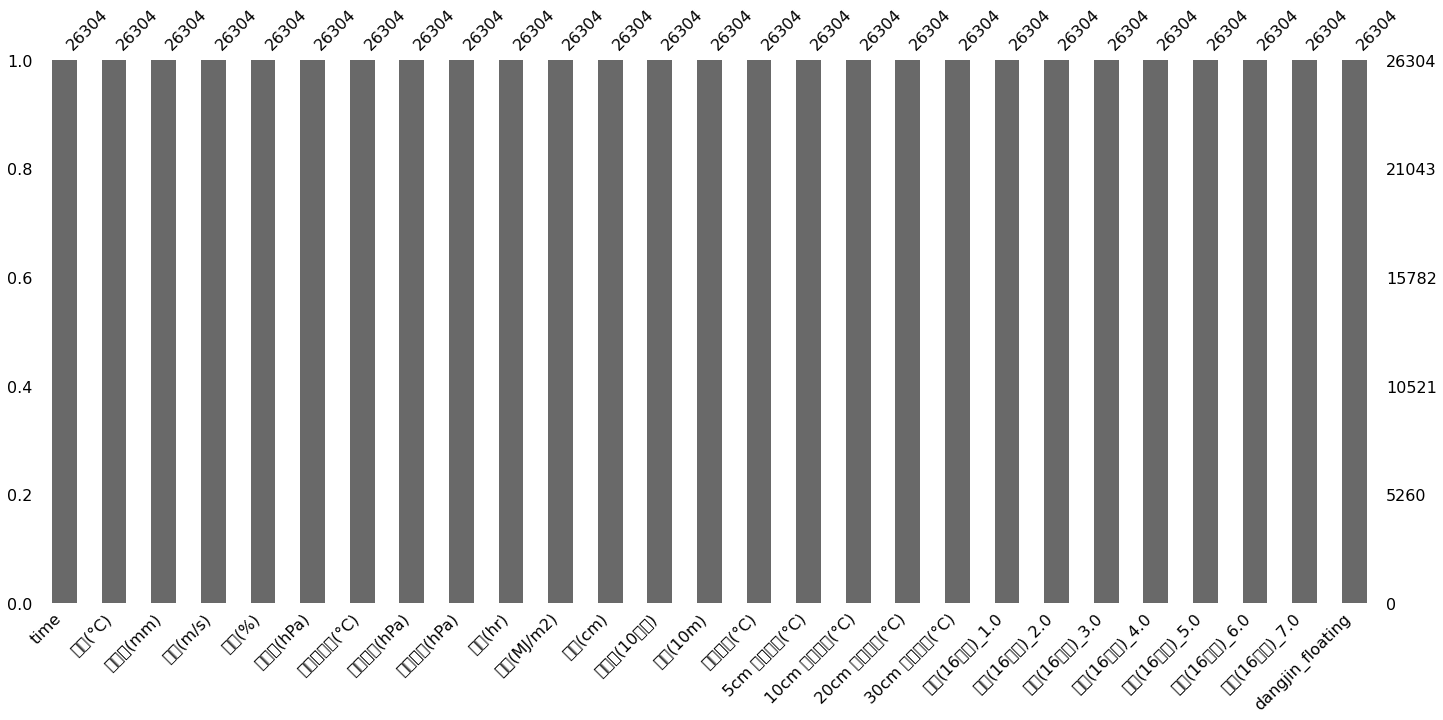

In [6]:
import missingno as msno
plt.rc('font', family='NanumBarunGothic')
msno.bar(data_obs)



In [7]:
data_fcst

,time_index,3시간기온,습도,풍속,하늘상태,강수형태,6시간강수량,6시간적설,일최고기온,일최저기온,강수확률,풍향_1.0,풍향_2.0,풍향_3.0,풍향_4.0,풍향_5.0,풍향_6.0,풍향_7.0
0,2018-01-01 00:00:00,0.265306,0.683183,0.206294,0.333333,0.00,0.0,0.0,0.288889,0.275000,0.111111,0,0,0,0,0,0,1
1,2018-01-01 01:00:00,0.243707,0.739084,0.185315,0.222222,0.00,0.0,0.0,0.290534,0.306346,0.074074,0,0,0,0,0,0,1
2,2018-01-01 02:00:00,0.230985,0.750636,0.164336,0.111111,0.00,0.0,0.0,0.290088,0.302377,0.037037,0,0,0,0,0,0,1
3,2018-01-01 03:00:00,0.244898,0.734296,0.143357,0.000000,0.00,0.0,0.0,0.288889,0.275000,0.000000,0,0,0,0,0,0,1
4,2018-01-01 04:00:00,0.234311,0.697991,0.136364,0.000000,0.00,0.0,0.0,0.288890,0.294797,0.000000,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26300,2020-12-31 20:00:00,0.226144,0.480187,0.207459,1.000000,0.25,0.0,0.0,0.208045,0.164824,0.444444,0,0,0,0,0,0,1
26301,2020-12-31 21:00:00,0.224490,0.427621,0.209790,1.000000,0.00,0.0,0.0,0.244444,0.175000,0.333333,0,0,0,0,0,0,1
26302,2020-12-31 22:00:00,0.228820,0.400466,0.186480,1.000000,0.00,0.0,0.0,0.233872,0.165135,0.333333,0,0,0,0,0,0,1
26303,2020-12-31 23:00:00,0.228879,0.427799,0.163170,1.000000,0.00,0.0,0.0,0.249916,0.165064,0.333333,0,0,0,0,0,0,1


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44053 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47049 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54413 missing from current font.
  font.set_

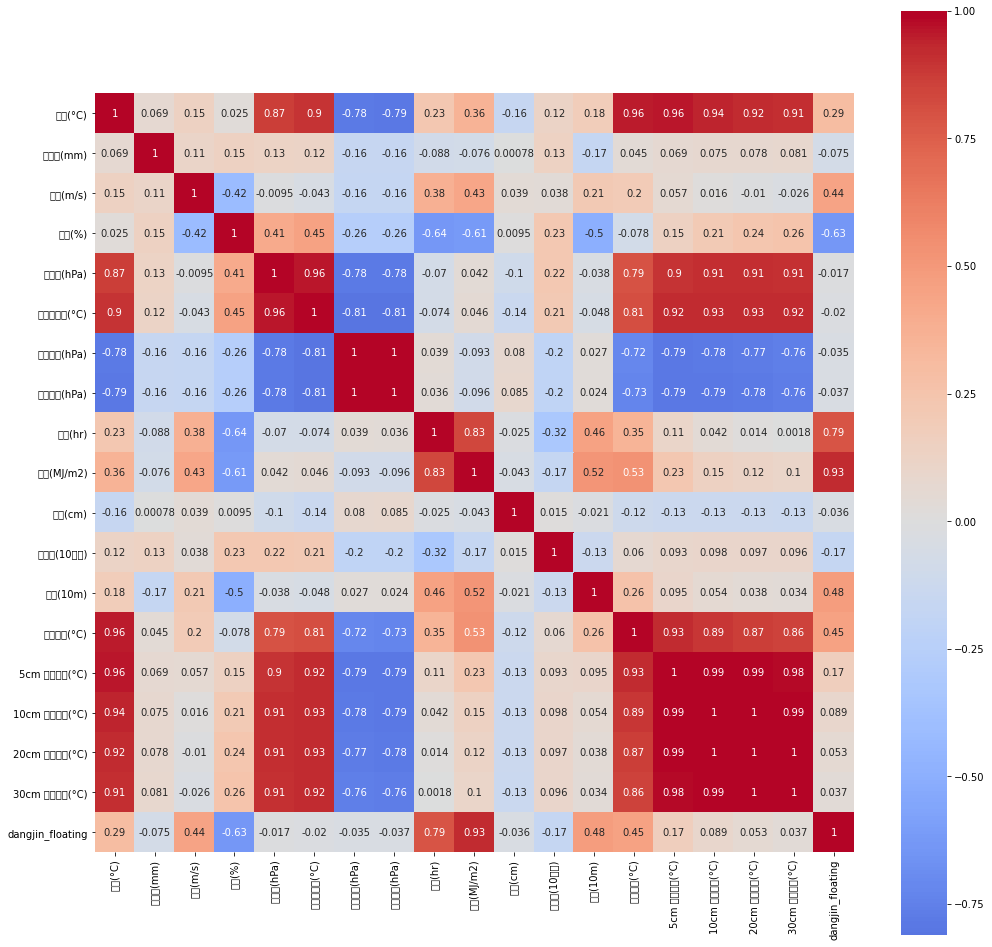

In [8]:
import seaborn as sns

plt.figure(figsize=(17, 17))
correlations = data_obs.drop(columns=['풍향(16방위)_1.0','풍향(16방위)_2.0','풍향(16방위)_3.0','풍향(16방위)_4.0','풍향(16방위)_5.0','풍향(16방위)_6.0','풍향(16방위)_7.0']).corr(method='pearson')

sns.heatmap(correlations, cmap="coolwarm", square=True, center=0, annot=True)



In [9]:
data_fcst

,time_index,3시간기온,습도,풍속,하늘상태,강수형태,6시간강수량,6시간적설,일최고기온,일최저기온,강수확률,풍향_1.0,풍향_2.0,풍향_3.0,풍향_4.0,풍향_5.0,풍향_6.0,풍향_7.0
0,2018-01-01 00:00:00,0.265306,0.683183,0.206294,0.333333,0.00,0.0,0.0,0.288889,0.275000,0.111111,0,0,0,0,0,0,1
1,2018-01-01 01:00:00,0.243707,0.739084,0.185315,0.222222,0.00,0.0,0.0,0.290534,0.306346,0.074074,0,0,0,0,0,0,1
2,2018-01-01 02:00:00,0.230985,0.750636,0.164336,0.111111,0.00,0.0,0.0,0.290088,0.302377,0.037037,0,0,0,0,0,0,1
3,2018-01-01 03:00:00,0.244898,0.734296,0.143357,0.000000,0.00,0.0,0.0,0.288889,0.275000,0.000000,0,0,0,0,0,0,1
4,2018-01-01 04:00:00,0.234311,0.697991,0.136364,0.000000,0.00,0.0,0.0,0.288890,0.294797,0.000000,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26300,2020-12-31 20:00:00,0.226144,0.480187,0.207459,1.000000,0.25,0.0,0.0,0.208045,0.164824,0.444444,0,0,0,0,0,0,1
26301,2020-12-31 21:00:00,0.224490,0.427621,0.209790,1.000000,0.00,0.0,0.0,0.244444,0.175000,0.333333,0,0,0,0,0,0,1
26302,2020-12-31 22:00:00,0.228820,0.400466,0.186480,1.000000,0.00,0.0,0.0,0.233872,0.165135,0.333333,0,0,0,0,0,0,1
26303,2020-12-31 23:00:00,0.228879,0.427799,0.163170,1.000000,0.00,0.0,0.0,0.249916,0.165064,0.333333,0,0,0,0,0,0,1


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44036 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49845 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_

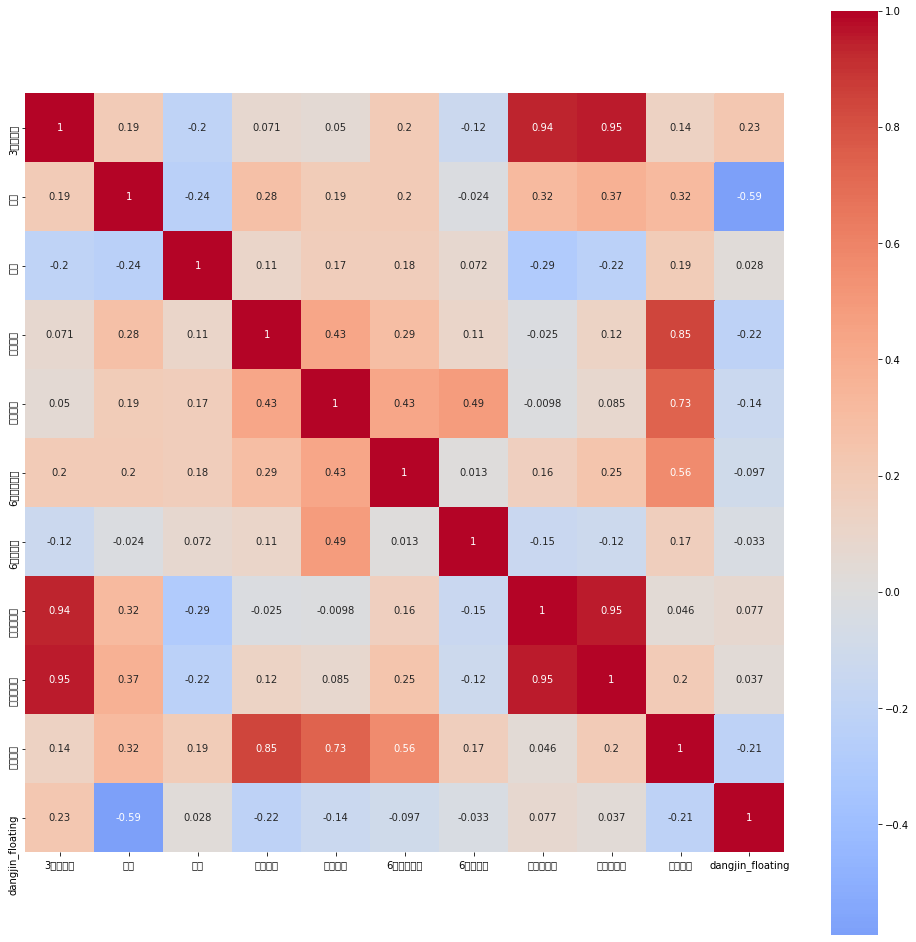

In [10]:
plt.figure(figsize=(17, 17))
data_fcst['dangjin_floating'] = data_obs['dangjin_floating']

correlations_fcst = data_fcst.drop(columns=['time_index','풍향_1.0','풍향_2.0','풍향_3.0','풍향_4.0','풍향_5.0','풍향_6.0','풍향_7.0']).corr(method='pearson')
sns.heatmap(correlations_fcst, cmap="coolwarm", square=True, center=0, annot=True)

In [11]:
data_fcst.drop(columns='dangjin_floating',inplace=True)

In [17]:


# feature selection 부분

#obs_select = list(data_obs.columns)    # 관측 데이터 중 포함시킬 컬럼
#obs_select = ['time','기온(°C)', '풍속(m/s)', '습도(%)', '일조(hr)', '일사(MJ/m2)', '시정(10m)', '지면온도(°C)','dangjin_floating']
obs_select = ['time', '풍속(m/s)', '습도(%)', '일조(hr)', '일사(MJ/m2)',  '지면온도(°C)','dangjin_floating']#'시정(10m)']
fcst_select = ['습도','3시간기온']
fcst_select = list(data_fcst.columns)  # 예보 데이터 중 포함시킬 컬럼

ndays = 1  # 과거 몇 일의 데이터를 포함해 현재의 예측에 반영해줄 것인지


inputs, outputs = utils.data_transform(data_obs, data_fcst, ndays, obs_select, fcst_select)



In [18]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
import Model

dataset = TensorDataset(inputs, outputs)
train_dataset, valid_dataset = random_split(dataset, [1066-ndays, 30])
train_dataloader = DataLoader(train_dataset, batch_size=64)
valid_dataloader = DataLoader(valid_dataset, batch_size=30)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# 모델 내부 하이퍼 파라미터 설정 부분

config = {'ndays' : ndays,
          'obs_input_size': len(obs_select)-2,
          'fcst_input_size': len(fcst_select)-1,
          'obs_hidden_size': 50,
          'fcst_hidden_size': 50,
          'hidden_size': 50,
          'dropout_ratio':0.3}



model = Model.model(config).to(device)



In [19]:
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

epochs = 100
best_valid_loss = float('inf')

for epoch in range(epochs):


    train_loss = utils.train(model, train_dataloader, device, optimizer)
    rmse, mae = utils.evaluate(model, valid_dataloader, device)

    if best_valid_loss > rmse :

        best_valid_loss = rmse
        torch.save(model.state_dict(), 'power generation forecast.pt')


    if epoch % 10 == 0 : 

        print(f'{epoch} epoch loss')
        print(f'Train |  {train_loss:.4f}    Valid | RMSE {rmse:.4f} | MAE {mae:.4f}')



0 epoch loss
Train |  216.8919    Valid | RMSE 169.0000 | MAE 111.0000
10 epoch loss
Train |  93.6592    Valid | RMSE 77.0000 | MAE 42.0000
20 epoch loss
Train |  80.0686    Valid | RMSE 80.0000 | MAE 42.0000
30 epoch loss
Train |  78.0130    Valid | RMSE 81.0000 | MAE 43.0000
40 epoch loss
Train |  73.6479    Valid | RMSE 90.0000 | MAE 46.0000
50 epoch loss
Train |  70.9266    Valid | RMSE 88.0000 | MAE 46.0000
60 epoch loss
Train |  65.9015    Valid | RMSE 92.0000 | MAE 47.0000
70 epoch loss
Train |  65.8545    Valid | RMSE 89.0000 | MAE 47.0000
80 epoch loss
Train |  67.1984    Valid | RMSE 86.0000 | MAE 45.0000
90 epoch loss
Train |  60.6009    Valid | RMSE 83.0000 | MAE 45.0000


In [20]:
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

epochs = 100
best_valid_loss = float('inf')

for epoch in range(epochs):


    train_loss = utils.train(model, train_dataloader, device, optimizer)
    rmse, mae = utils.evaluate(model, valid_dataloader, device)

    if best_valid_loss > rmse :

        best_valid_loss = rmse
        torch.save(model.state_dict(), 'power generation forecast.pt')


    if epoch % 10 == 0 : 

        print(f'{epoch} epoch loss')
        print(f'Train |  {train_loss:.4f}    Valid | RMSE {rmse:.4f} | MAE {mae:.4f}')



0 epoch loss
Train |  61.1012    Valid | RMSE 102.0000 | MAE 54.0000
10 epoch loss
Train |  58.6526    Valid | RMSE 92.0000 | MAE 48.0000
20 epoch loss
Train |  51.6176    Valid | RMSE 93.0000 | MAE 47.0000
30 epoch loss
Train |  50.0352    Valid | RMSE 95.0000 | MAE 49.0000
40 epoch loss
Train |  49.6043    Valid | RMSE 92.0000 | MAE 47.0000
50 epoch loss
Train |  51.1216    Valid | RMSE 99.0000 | MAE 50.0000
60 epoch loss
Train |  46.2840    Valid | RMSE 97.0000 | MAE 48.0000
70 epoch loss
Train |  52.1833    Valid | RMSE 93.0000 | MAE 48.0000
80 epoch loss
Train |  45.7668    Valid | RMSE 94.0000 | MAE 47.0000
90 epoch loss
Train |  44.2908    Valid | RMSE 89.0000 | MAE 45.0000
